In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220615_00 import UserModel
from models.user_simulator import UserSimulator
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220615_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=80, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=2, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [5]:
simulator = UserSimulator(model)

In [6]:
test_dataset[20]

(array([3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([168, 168, 166, 167, 168, 168, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 179, 179, 180, 180]),
 array([2, 3, 4, 4, 4, 4, 2, 2, 4, 2, 3, 3, 4, 2, 3, 2, 3, 4, 3, 3, 3, 2,
        4,

In [7]:
# 0, 1, 3, 5, 19, 20
c1_seq, c2_seq, d_seq, r_seq = test_dataset[20]

c1_seq, c1shft_seq = [c1_seq[:-1]], [c1_seq[1:]]

c2_seq, c2shft_seq = [c2_seq[:-1]], [c2_seq[1:]]

d_seq, dshft_seq = [d_seq[:-1]], [d_seq[1:]]

r_seq, rshft_seq = [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

c1_seq = np.array([[0] * seq_len])
c2_seq = np.array([[0] * seq_len])
d_seq = np.array([[4] * seq_len])

In [8]:
alpha_seq, r_seq, h_seq, C1_seq, C2_seq = simulator.simulate(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
    LongTensor(d_seq),
)

# c1_one_hot_seq: [batch_size, seq_len, 1, num_c1]
# c2_one_hot_seq: [batch_size, seq_len, 1, num_c2]
c1_one_hot_seq = one_hot(LongTensor(c1_seq), dataset.num_c1).float()
c1_one_hot_seq = torch.reshape(
    c1_one_hot_seq,
    shape=[
        -1,
        c1_one_hot_seq.shape[1],
        c1_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta1_seq = torch.bmm(
    torch.reshape(
        c1_one_hot_seq,
        shape=[
            -1,
            c1_one_hot_seq.shape[2],
            c1_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C1_seq, shape=[-1, C1_seq.shape[2], C1_seq.shape[3]]
    )
)
beta1_seq = torch.reshape(
    beta1_seq, shape=[1, seq_len]
)

c2_one_hot_seq = one_hot(LongTensor(c2_seq), dataset.num_c2).float()
c2_one_hot_seq = torch.reshape(
    c2_one_hot_seq,
    shape=[
        -1,
        c2_one_hot_seq.shape[1],
        c2_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta2_seq = torch.bmm(
    torch.reshape(
        c2_one_hot_seq,
        shape=[
            -1,
            c2_one_hot_seq.shape[2],
            c2_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C2_seq, shape=[-1, C2_seq.shape[2], C2_seq.shape[3]]
    )
)
beta2_seq = torch.reshape(
    beta2_seq, shape=[1, seq_len]
)

gamma_seq = model.D(LongTensor(d_seq)).squeeze()
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

r_seq = r_seq.detach().cpu().numpy()

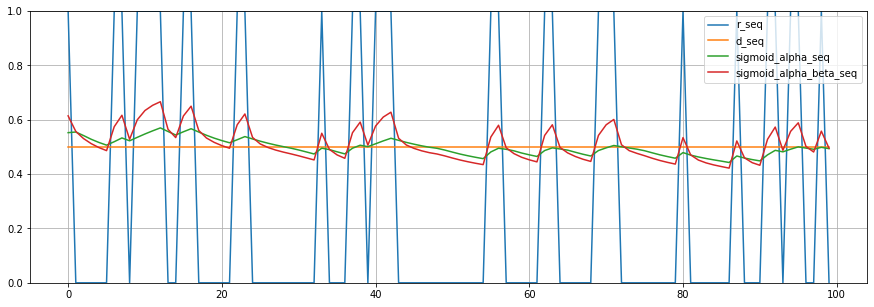

In [9]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

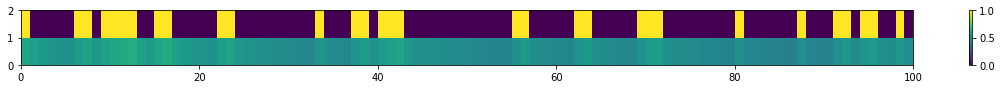

In [10]:
plt.figure(figsize=[20, (len(np.unique(c2_seq)) + 1) // 2], facecolor="white")
temp = np.concatenate([CQ_seq[:, np.unique(c2_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [11]:
seq_len = 100

c1_seq = np.array([[0] * seq_len])
c2_seq = np.array([[0] * seq_len])

alpha_seq, d_seq, r_seq, h_seq, C1_seq, C2_seq = simulator.expectimax(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
)

# c1_one_hot_seq: [batch_size, seq_len, 1, num_c1]
# c2_one_hot_seq: [batch_size, seq_len, 1, num_c2]
c1_one_hot_seq = one_hot(LongTensor(c1_seq), dataset.num_c1).float()
c1_one_hot_seq = torch.reshape(
    c1_one_hot_seq,
    shape=[
        -1,
        c1_one_hot_seq.shape[1],
        c1_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta1_seq = torch.bmm(
    torch.reshape(
        c1_one_hot_seq,
        shape=[
            -1,
            c1_one_hot_seq.shape[2],
            c1_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C1_seq, shape=[-1, C1_seq.shape[2], C1_seq.shape[3]]
    )
)
beta1_seq = torch.reshape(
    beta1_seq, shape=[1, seq_len]
)

c2_one_hot_seq = one_hot(LongTensor(c2_seq), dataset.num_c2).float()
c2_one_hot_seq = torch.reshape(
    c2_one_hot_seq,
    shape=[
        -1,
        c2_one_hot_seq.shape[1],
        c2_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta2_seq = torch.bmm(
    torch.reshape(
        c2_one_hot_seq,
        shape=[
            -1,
            c2_one_hot_seq.shape[2],
            c2_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C2_seq, shape=[-1, C2_seq.shape[2], C2_seq.shape[3]]
    )
)
beta2_seq = torch.reshape(
    beta2_seq, shape=[1, seq_len]
)

gamma_seq = model.D(LongTensor(d_seq)).squeeze()
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

d_seq = d_seq.detach().cpu().numpy()
r_seq = r_seq.detach().cpu().numpy()

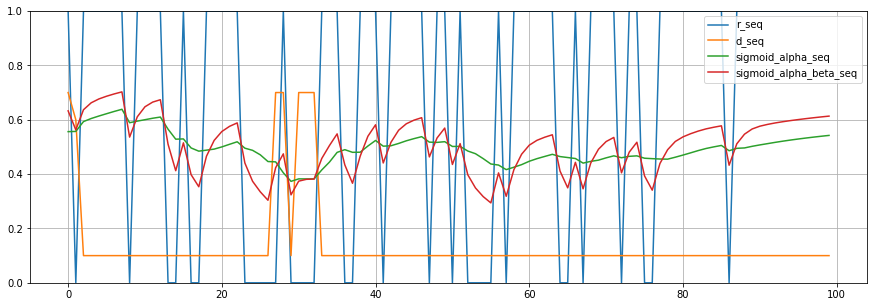

In [12]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

In [13]:
import json

from rl_models.pg import PolicyGradient
from rl_models.ac import ActorCritic
from rl_models.trpo import TRPO
from rl_models.gae import GAE
from rl_models.ppo import PPO

model_name = "trpo"

with open(os.path.join("rl_models", "config.json")) as f:
    config = json.load(f)[model_name]

discrete = True
state_dim = simulator.state_dim
action_dim = simulator.action_dim

if model_name == "trpo":
    policy = TRPO(
        state_dim, action_dim, discrete, **config
    ).to(device)

    policy.pi.load_state_dict(
        torch.load(
            "ckpts/rl/trpo/policy.ckpt",
            map_location=device
        )
    )
    policy.v.load_state_dict(
        torch.load(
            "ckpts/rl/trpo/value.ckpt",
            map_location=device
        )
    )
elif model_name == "ppo":
    policy = PPO(
        state_dim, action_dim, discrete, **config
    ).to(device)

    policy.pi.load_state_dict(
        torch.load(
            "ckpts/rl/ppo/policy.ckpt",
            map_location=device
        )
    )
    policy.v.load_state_dict(
        torch.load(
            "ckpts/rl/ppo/value.ckpt",
            map_location=device
        )
    )
elif model_name == "gae":
    policy = GAE(
        state_dim, action_dim, discrete, **config
    ).to(device)

    policy.pi.load_state_dict(
        torch.load(
            "ckpts/rl/gae/policy.ckpt",
            map_location=device
        )
    )
    policy.v.load_state_dict(
        torch.load(
            "ckpts/rl/gae/value.ckpt",
            map_location=device
        )
    )

In [20]:
seq_len = 100

c1_seq = np.array([[0] * seq_len])
c2_seq = np.array([[0] * seq_len])

alpha_seq, d_seq, r_seq, h_seq, C1_seq, C2_seq = simulator.rl_policy(
    policy,
    LongTensor(c1_seq),
    LongTensor(c2_seq),
)

# c1_one_hot_seq: [batch_size, seq_len, 1, num_c1]
# c2_one_hot_seq: [batch_size, seq_len, 1, num_c2]
c1_one_hot_seq = one_hot(LongTensor(c1_seq), dataset.num_c1).float()
c1_one_hot_seq = torch.reshape(
    c1_one_hot_seq,
    shape=[
        -1,
        c1_one_hot_seq.shape[1],
        c1_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta1_seq = torch.bmm(
    torch.reshape(
        c1_one_hot_seq,
        shape=[
            -1,
            c1_one_hot_seq.shape[2],
            c1_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C1_seq, shape=[-1, C1_seq.shape[2], C1_seq.shape[3]]
    )
)
beta1_seq = torch.reshape(
    beta1_seq, shape=[1, seq_len]
)

c2_one_hot_seq = one_hot(LongTensor(c2_seq), dataset.num_c2).float()
c2_one_hot_seq = torch.reshape(
    c2_one_hot_seq,
    shape=[
        -1,
        c2_one_hot_seq.shape[1],
        c2_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta2_seq = torch.bmm(
    torch.reshape(
        c2_one_hot_seq,
        shape=[
            -1,
            c2_one_hot_seq.shape[2],
            c2_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C2_seq, shape=[-1, C2_seq.shape[2], C2_seq.shape[3]]
    )
)
beta2_seq = torch.reshape(
    beta2_seq, shape=[1, seq_len]
)

gamma_seq = model.D(LongTensor(d_seq)).squeeze()
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

d_seq = d_seq.detach().cpu().numpy()
r_seq = r_seq.detach().cpu().numpy()

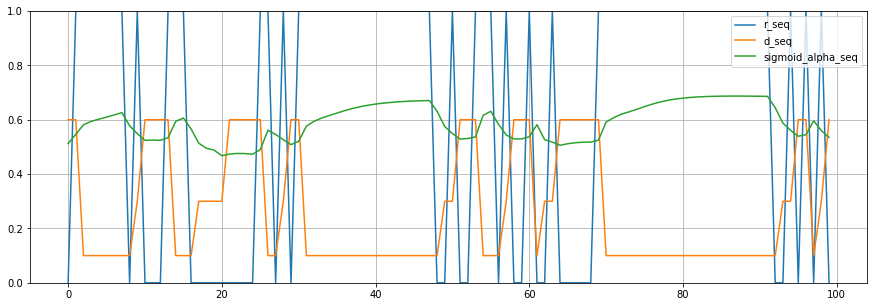

In [21]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

In [16]:
h_seq.flatten()

tensor([ 0.4735,  0.0403,  0.0475,  ..., -0.6378,  0.5525,  0.1586],
       grad_fn=<ViewBackward>)

In [17]:
C1_seq.flatten().detach().cpu().numpy()

array([-0.01453581,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

(array([ 9., 11.,  7., 13., 15., 13., 12., 12.,  7.,  5., 23., 14., 14.,
        22.,  9.,  8., 58., 11.,  7., 20., 14., 33., 34., 15., 12., 16.,
        17., 30., 32., 29., 19., 24., 26., 26., 16., 22., 26., 15., 34.,
        39., 34., 34., 30., 37., 43., 24., 45., 36., 42., 43., 37., 41.,
        34., 31., 28., 32., 17., 31., 44., 33., 30., 37., 34., 36., 42.,
        31., 34., 22., 17., 20., 17., 15., 15.,  9.,  9., 19., 11., 16.,
         7., 12., 14., 17., 12.,  6.,  6.,  2.,  2.,  3.,  7.,  8.,  7.,
         4.,  2.,  2.,  2.,  0.,  1.,  2.,  1.,  4.]),
 array([-0.8642584 , -0.84576094, -0.8272634 , -0.80876595, -0.7902684 ,
        -0.77177095, -0.7532734 , -0.73477596, -0.71627843, -0.69778097,
        -0.67928344, -0.660786  , -0.64228845, -0.623791  , -0.60529345,
        -0.586796  , -0.56829846, -0.549801  , -0.5313035 , -0.512806  ,
        -0.4943085 , -0.475811  , -0.4573135 , -0.438816  , -0.4203185 ,
        -0.40182105, -0.38332355, -0.36482605, -0.34632856, -0.327831

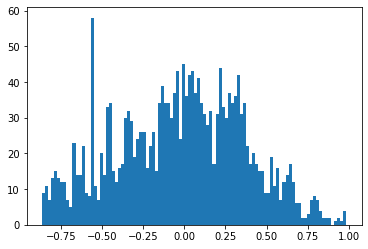

In [18]:
plt.hist(h_seq.flatten().detach().cpu().numpy(), bins=100)

(array([ 2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  3.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  6.,  4.,  0.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.,  3.,  1.,  0.,  6.,  6., 39.,  1.,  1.]),
 array([-0.2181434 , -0.21441361, -0.21068384, -0.20695405, -0.20322427,
        -0.19949448, -0.19576469, -0.19203492, -0.18830512, -0.18457535,
        -0.18084556, -0.17711578, -0.173386  , -0.1696562 , -0.16592643,
        -0.16219664, -0.15846686, -0.15473707, -0.15100728, -0.1472775 ,
        -0.14354771, -0.13981794, -0.13608815, -0.13235836, -0.12862858,
        -0.12489879, -0.12116901, -0.11743923, -0.11370944, -0.109979

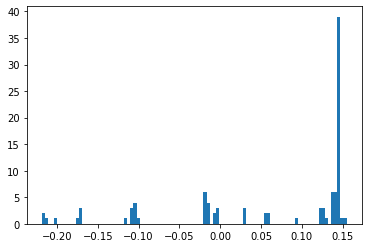

In [19]:
temp = C1_seq.flatten().detach().cpu().numpy()

plt.hist(temp[temp != 0], bins=100)